In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [2]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [4]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()



<h2>1.  Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [24]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [5]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [7]:
import nltk
nltk.download('stopwords')

def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to C:\Users\udaya
[nltk_data]     sameer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

import nltk
nltk.download('punkt')

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

[nltk_data] Downloading package punkt to C:\Users\udaya
[nltk_data]     sameer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:16:12.559094


In [9]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

__ Saving Preprocessed data to a Database __

In [10]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

__ Converting string Tags to multilable output variables __ 

In [11]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [12]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

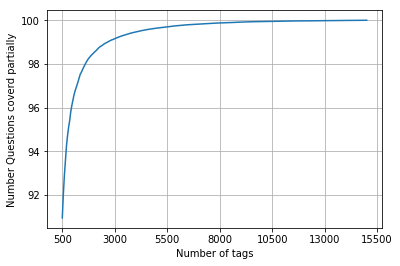

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [13]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [31]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [32]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [38]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [39]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:07.130698


In [40]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94928) Y : (400000, 500)
Dimensions of test data X: (99998, 94928) Y: (99998, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [40]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23609
Hamming loss  0.00278296
Micro-average quality numbers
Precision: 0.7214, Recall: 0.3249, F1-measure: 0.4480
Macro-average quality numbers
Precision: 0.5470, Recall: 0.2572, F1-measure: 0.3341
             precision    recall  f1-score   support

          0       0.94      0.64      0.76      5519
          1       0.69      0.26      0.37      8190
          2       0.81      0.37      0.51      6529
          3       0.81      0.43      0.56      3231
          4       0.81      0.41      0.54      6430
          5       0.82      0.34      0.48      2879
          6       0.87      0.50      0.63      5086
          7       0.88      0.54      0.67      4533
          8       0.61      0.13      0.22      3000
          9       0.82      0.52      0.63      2765
         10       0.59      0.17      0.26      3051
         11       0.70      0.33      0.45      3009
         12       0.65      0.25      0.36      2630
         13       0.71      0.23      0.35   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

In [0]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25108
Hamming loss  0.00270302
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3672, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5570, Recall: 0.2950, F1-measure: 0.3710
             precision    recall  f1-score   support

          0       0.94      0.72      0.82      5519
          1       0.70      0.34      0.45      8190
          2       0.80      0.42      0.55      6529
          3       0.82      0.49      0.61      3231
          4       0.80      0.44      0.57      6430
          5       0.82      0.38      0.52      2879
          6       0.86      0.53      0.66      5086
          7       0.87      0.58      0.70      4533
          8       0.60      0.13      0.22      3000
          9       0.82      0.57      0.67      2765
         10       0.60      0.20      0.30      3051
         11       0.68      0.38      0.49      3009
         12       0.62      0.29      0.40      2630
         13       0.73      0.30      0.43   

<h1> 5. Assignments </h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

### 5.1 BOW upto 4 grams, computing micro f1 score with LR (OVR)

In [41]:
start = datetime.now()

vectorizer6 = CountVectorizer(min_df=10,ngram_range=(1,4))

x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)



Time taken to run this cell : 0:03:14.075636


In [42]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25109
Hamming loss  0.00270294
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3673, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5570, Recall: 0.2950, F1-measure: 0.3710
             precision    recall  f1-score   support

          0       0.94      0.72      0.82      5519
          1       0.70      0.34      0.45      8190
          2       0.80      0.42      0.55      6529
          3       0.82      0.49      0.61      3231
          4       0.80      0.44      0.57      6430
          5       0.82      0.38      0.52      2879
          6       0.86      0.53      0.66      5086
          7       0.87      0.58      0.70      4533
          8       0.60      0.13      0.22      3000
          9       0.82      0.57      0.67      2765
         10       0.60      0.20      0.30      3051
         11       0.68      0.38      0.49      3009
         12       0.62      0.29      0.40      2630
         13       0.73      0.30      0.43   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 5.2 Hyper Parameter tuning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


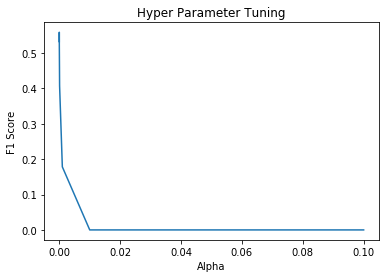

NameError: name 'bestalpha' is not defined

In [44]:
from sklearn import cross_validation
import matplotlib.pyplot as plt

start = datetime.now()

alpha_list=[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]

grid_alpha={}

X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_multilabel, y_train, test_size=0.3)

for alpha_ in alpha_list:
    #print(i)
    #alpha_=alpha_*(10**i)
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=alpha_, penalty='l1'), n_jobs=-1)
    classifier.fit(X_tr, y_tr)
    pred_cv=classifier.predict(X_cv)
    f1 = f1_score(y_cv, pred_cv, average='micro')
    grid_alpha[alpha_]=f1

m=max(zip(grid_alpha.values(), grid_alpha.keys()))
bestalpha_LR=m[1]




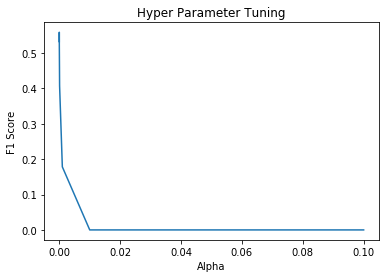

Beast value of hyper parameter alpha found at {0.000001}
Accuracy : 0.25223
Hamming loss  0.00271444
Micro-average quality numbers
Precision: 0.6978, Recall: 0.3865, F1-measure: 0.4975
Macro-average quality numbers
Precision: 0.5521, Recall: 0.3092, F1-measure: 0.3827
             precision    recall  f1-score   support

          0       0.94      0.75      0.83      5519
          1       0.65      0.37      0.47      8190
          2       0.78      0.43      0.55      6529
          3       0.81      0.52      0.63      3231
          4       0.76      0.46      0.58      6430
          5       0.80      0.39      0.53      2879
          6       0.85      0.56      0.67      5086
          7       0.84      0.61      0.70      4533
          8       0.56      0.15      0.23      3000
          9       0.80      0.59      0.68      2765
         10       0.55      0.25      0.34      3051
         11       0.67      0.41      0.51      3009
         12       0.58      0.33      0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
plt.title('Hyper Parameter Tuning')
plt.ylabel('F1 Score')
plt.xlabel('Alpha')
plt.plot(grid_alpha.keys(), grid_alpha.values())
plt.show()

print('Beast value of hyper parameter alpha found at {%f}'%bestalpha_LR)
    
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=bestalpha_LR, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')

f1_LR_Micro = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1_LR_Micro))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1_LR_Macro = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1_LR_Macro))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

### 5.3 SVM ( SGD Classifier with hinge loss)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


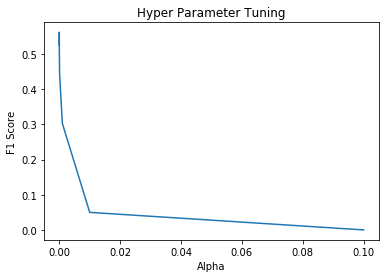

Beast value of hyper parameter alpha found at {0.000001}
Accuracy : 0.26115
Hamming loss  0.00267414
Micro-average quality numbers
Precision: 0.7063, Recall: 0.3949, F1-measure: 0.5066
Macro-average quality numbers
Precision: 0.5472, Recall: 0.3091, F1-measure: 0.3718
             precision    recall  f1-score   support

          0       0.92      0.78      0.85      5519
          1       0.61      0.39      0.48      8190
          2       0.74      0.47      0.58      6529
          3       0.79      0.53      0.64      3231
          4       0.72      0.49      0.59      6430
          5       0.75      0.45      0.56      2879
          6       0.83      0.57      0.67      5086
          7       0.83      0.62      0.71      4533
          8       0.55      0.16      0.25      3000
          9       0.76      0.58      0.66      2765
         10       0.52      0.25      0.34      3051
         11       0.64      0.45      0.53      3009
         12       0.58      0.34      0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
from sklearn import cross_validation
import matplotlib.pyplot as plt

start = datetime.now()

alpha_list=[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]

grid_alpha={}

X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(x_train_multilabel, y_train, test_size=0.3)

for alpha_ in alpha_list:
    #print(i)
    #alpha_=alpha_*(10**i)
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=alpha_, penalty='l1'), n_jobs=-1)
    classifier.fit(X_tr, y_tr)
    pred_cv=classifier.predict(X_cv)
    f1 = f1_score(y_cv, pred_cv, average='micro')
    grid_alpha[alpha_]=f1

m=max(zip(grid_alpha.values(), grid_alpha.keys()))
bestalpha_SVM=m[1]

plt.title('Hyper Parameter Tuning')
plt.ylabel('F1 Score')
plt.xlabel('Alpha')
plt.plot(grid_alpha.keys(), grid_alpha.values())
plt.show()

print('Beast value of hyper parameter alpha found at {%f}'%bestalpha_SVM)
    
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=bestalpha_SVM, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1_SVM_Micro = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1_SVM_Micro))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1_SVM_Macro = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1_SVM_Macro))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [52]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Method", "Vectorizer","Hyper Parameter", "F1-Score-Micro","F1-Score-Macro"]

x.add_row(["LR","BOW",bestalpha_LR,f1_LR_Micro,f1_LR_Macro])
x.add_row(["SVM","BOW",bestalpha_SVM,f1_SVM_Micro,f1_SVM_Macro])

print(x)

+--------+------------+-----------------+--------------------+---------------------+
| Method | Vectorizer | Hyper Parameter |   F1-Score-Micro   |    F1-Score-Macro   |
+--------+------------+-----------------+--------------------+---------------------+
|   LR   |    BOW     |      1e-06      | 0.4974785435534394 |  0.3827273771783078 |
|  SVM   |    BOW     |      1e-06      | 0.5065998501795264 | 0.37183907660975823 |
+--------+------------+-----------------+--------------------+---------------------+


# Summary

In this assignment, the following procedure is adapted. 

1. Bag of words is used as feature extractor with upto 4 grams
2. Micro F1 Score is computed with Logistic Regression using One vs Rest classifier
3. Hyper parameter tuning is performed for the parameter alpha and the best alpha is estimated
4. The performance is improved with the best alpha
5. Similar procedure is followed for the Linear-SVM classifier (SGDClassifier with hinge loss)
6. The best hyper parameter is found using grid search and the results are reported
 
